In [1]:
import pandas as pd 
import numpy as np 
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from gensim.models import word2vec
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import json
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('book30-listing-train.csv',encoding='latin1')

In [5]:
s = pd.Series([i for i in range(len(df))])
#book_data['index'] = range(1, len(book_data) + 1)
#book_data['index'] = book_data.index

inds = pd.Series(s, index=s)

In [6]:
df.insert(0, 'index',inds.values)

In [7]:
index_name = df.index.name
print(index_name)



None


book_data.index.name='index'
index_name = book_data.index.name
print(index_name)

In [8]:
df.columns  = ['index','asin', 'filename', 'image_url', 'title', 'author', 'category_id', 'category']

In [9]:
 df.head()

,index,asin,filename,image_url,title,author,category_id,category
0,0,1404803335,1404803335.jpg,http://ecx.images-amazon.com/images/I/51UJnL3T...,"Magnets: Pulling Together, Pushing Apart (Amaz...",Natalie M. Rosinsky,4,Children's Books
1,1,1446276082,1446276082.jpg,http://ecx.images-amazon.com/images/I/51MGUKhk...,Energy Security (SAGE Library of International...,NaN,10,Engineering & Transportation
2,2,1491522666,1491522666.jpg,http://ecx.images-amazon.com/images/I/51qKvjsi...,An Amish Gathering: Life in Lancaster County,Beth Wiseman,9,Christian Books & Bibles
3,3,970096410,0970096410.jpg,http://ecx.images-amazon.com/images/I/51qoUENb...,City of Rocks Idaho: A Climber's Guide (Region...,Dave Bingham,26,Sports & Outdoors
4,4,8436808053,8436808053.jpg,http://ecx.images-amazon.com/images/I/41aDW5pz...,"Como vencer el insomnio. Tecnicas, reglas y co...",Choliz Montanes,11,"Health, Fitness & Dieting"


In [10]:
df.columns

Index(['index', 'asin', 'filename', 'image_url', 'title', 'author',
       'category_id', 'category'],
      dtype='object')

In [11]:
df.isnull().sum()

index             0
asin              0
filename          0
image_url         0
title             0
author         3437
category_id       0
category          0
dtype: int64

In [22]:
book_data= df[['title', 'category']]
book_data["title"] = book_data["title"].str.lower()
book_data['category'] = book_data['category'].str.lower()
print(book_data.shape)

(51299, 2)


In [23]:
book_data.dropna()

,title,category
0,"magnets: pulling together, pushing apart (amaz...",children's books
1,energy security (sage library of international...,engineering & transportation
2,an amish gathering: life in lancaster county,christian books & bibles
3,city of rocks idaho: a climber's guide (region...,sports & outdoors
4,"como vencer el insomnio. tecnicas, reglas y co...","health, fitness & dieting"
...,...,...
51294,extreme prey,"mystery, thriller & suspense"
51295,the crime writer's guide to police practice an...,"mystery, thriller & suspense"
51296,the jezebel remedy: a novel,"mystery, thriller & suspense"
51297,startup,"mystery, thriller & suspense"


## Data Pre-Processing
1. remove stopwords and 
2. remove punctuations such as ? %#%^@#W^
3. remove any urls 
4. lemmetize the word in each row

In [32]:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [33]:
stop = set(stopwords.words('english'))

In [34]:
lemmatizer = WordNetLemmatizer()


In [35]:
def data_preprocessing(text):
    text = ' '.join(re.sub('https?://\S+|www\.\S+','',text).split())
    text = text.replace('\n', '')
    text = re.sub("[!@#$+%*:()/<.=,—']", '', text)
    text = ' '.join([word for word in text.split() if word not in stop])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [36]:
book_data['title'] = book_data['title'].apply(lambda x: data_preprocessing(x))

In [37]:
book_data['category'] = book_data['category'].apply(lambda x: data_preprocessing(x))

In [38]:
book_data.head()

,title,category
0,magnet pulling together pushing apart amazing ...,childrens book
1,energy security sage library international sec...,engineering & transportation
2,amish gathering life lancaster county,christian book & bible
3,city rock idaho climber guide regional rock cl...,sport & outdoors
4,como vencer el insomnio tecnicas reglas consej...,health fitness & dieting


In [39]:
book_data.reset_index()

,index,title,category
0,0,magnet pulling together pushing apart amazing ...,childrens book
1,1,energy security sage library international sec...,engineering & transportation
2,2,amish gathering life lancaster county,christian book & bible
3,3,city rock idaho climber guide regional rock cl...,sport & outdoors
4,4,como vencer el insomnio tecnicas reglas consej...,health fitness & dieting
...,...,...,...
51294,51294,extreme prey,mystery thriller & suspense
51295,51295,crime writer guide police practice procedure,mystery thriller & suspense
51296,51296,jezebel remedy novel,mystery thriller & suspense
51297,51297,startup,mystery thriller & suspense


## EDA and DV
- Data Visualization and EXploratory Data Analysis
- word cloud will generate a word based on the book name 

In [42]:
bookCorpus = book_data.title.values

Text(0.5, 1.0, 'Figure 1. Books name Corpus Word Clould.. ')

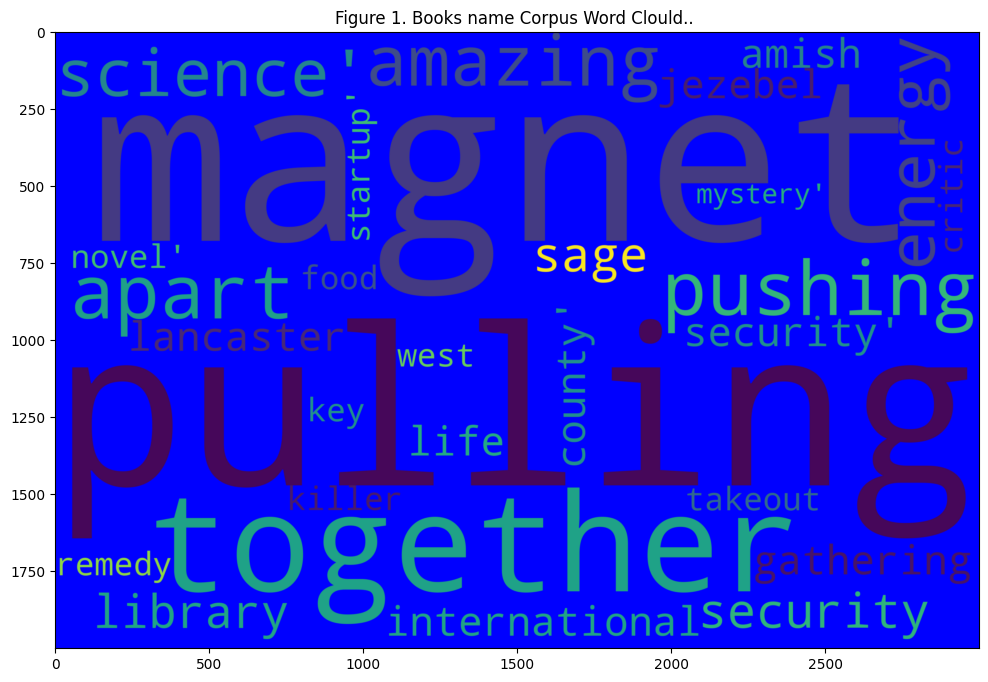

In [45]:
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 3000, height = 2000, background_color='blue', max_words=1000).generate(str(bookCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Figure 1. Books name Corpus Word Clould.. ')

In [44]:
categoryCorpus = book_data.category.values

Text(0.5, 1.0, 'Figure 1. Books Category Corpus Word Clould.. ')

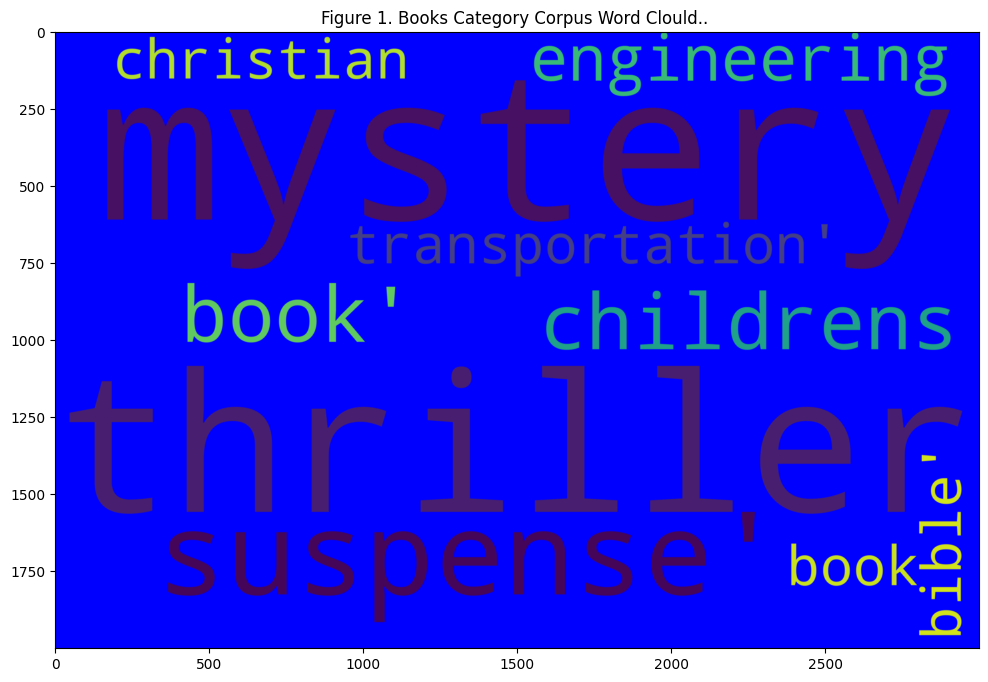

In [46]:
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 3000, height = 2000, background_color='blue', max_words=1000).generate(str(categoryCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Figure 1. Books Category Corpus Word Clould.. ')

## Model selection and fitting to data¶

- Readers will have hard time finding their favourate book. Therefore, our goal is to facilate the users interest. 

- We apply the following steps to fullfill these modeling:

1. tokenize the sentence in each row of the title (book_name) and category. 
2. create two new columns accordingly.
3. implement word2vec method ( an embedding method) as feature extractions by averaging vectors from the words of each row.
4. append the vectors of each row to two new columns [title_embedding, category_embedding]. 
5. Using 'word2vec' embedding method to embed the reader 'user' query input
6. calculate the cosine similarity (similarity score, confidence similarity) between the query vector and entire title embedding column
7. create a new column 'confidence_score' to append the above similarity score.
8. show the top 'k' recommended books according to the highest cosine score.



In [54]:
tokenized_sentences_title = [sentence.split() for sentence in book_data['title'].values]

In [55]:
tokenized_sentences_category = [sentence.split() for sentence in book_data['category'].values]

In [56]:
book_data['title_tokenized'] =  tokenized_sentences_title

In [57]:
book_data['category_tokenized'] = tokenized_sentences_category

In [59]:
# ini the model
model = word2vec.Word2Vec(tokenized_sentences_title, vector_size = 100, min_count=1)

In [108]:
# averging all words vectors in a sentence  
def build_word_vector(sentence, size):
    vector = np.zeros(size)
    count = 0.
    for word in sentence:
        if word in model.wv:
            #print(word)
            vector += model.wv[word]
            count += 1.
    if count != 0:
        vector /= count
        
    return vector 
    

In [109]:
book_data['title_embedding'] = book_data['title_tokenized'].apply(lambda x: build_word_vector(x, size=100))

In [62]:
book_data['category_embedding'] = book_data['category_tokenized'].apply(lambda x: build_word_vector(x, size=100))

In [63]:
book_data.head()

,title,category,title_tokenized,category_tokenized,title_embedding,category_embedding
0,magnet pulling together pushing apart amazing ...,childrens book,"[magnet, pulling, together, pushing, apart, am...","[childrens, book]","[0.08869108404698116, 0.22384974480207478, 0.1...","[0.02652547787874937, 0.5800278931856155, 0.15..."
1,energy security sage library international sec...,engineering & transportation,"[energy, security, sage, library, internationa...","[engineering, &, transportation]","[0.11929521864900987, 0.5751244525114695, 0.49...","[0.048634874013563, 0.7220096836487452, 0.4315..."
2,amish gathering life lancaster county,christian book & bible,"[amish, gathering, life, lancaster, county]","[christian, book, &, bible]","[0.1621046107262373, 0.22792935669422149, -0.0...","[0.063528475118801, 0.8210734650492668, 0.2969..."
3,city rock idaho climber guide regional rock cl...,sport & outdoors,"[city, rock, idaho, climber, guide, regional, ...","[sport, &, outdoors]","[0.0983159944945429, 0.5081673281060325, 0.209...","[0.03711644963671764, 0.7049262349804243, 0.29..."
4,como vencer el insomnio tecnicas reglas consej...,health fitness & dieting,"[como, vencer, el, insomnio, tecnicas, reglas,...","[health, fitness, &, dieting]","[-0.08203902221284806, 0.30150174039105576, 0....","[0.21957755059702322, 0.6401724219322205, 0.36..."


In [133]:
# embedding and averaging the user query input

def embedding_query(query):
    query = query.split(' ')
    query_vector = np.zeros(100).reshape((1, 100))
    count = 0.
    for word in query:
        if word in model.wv:
            query_vector += model.wv[word]
            count += 1.
    if count != 0:
        query_vector /= count 
    return query_vector 
    

In [134]:
#query = "An Amish Gathering: Life in Lancaster County"
#query = "amish gathering life lancaster county 	"
query = input()

An Amish Gathering: Life in Lancaster County


In [136]:
query = data_preprocessing(query.lower())

In [137]:
print(query)

amish gathering life lancaster county


In [138]:
# find the n_top closest books to the query input 

def get_recommended_books(query, n_tops):
    query_vector = embedding_query(query)
    
    book_data['confidence_similarity'] = book_data["title_embedding"].apply(
        lambda x: metrics.pairwise.cosine_similarity(
            [x], query_vector.reshape(1, -1))[0][0])
    
    top_suggested_books = (book_data.sort_values("confidence_similarity", ascending=False)
                          [["title", "category", "confidence_similarity"]]
                          .drop_duplicates()[:n_tops])
    
    
    return top_suggested_books
    
        
        
    
    
    

In [139]:
# grab the recommended list of books for the follwoing book

#get_recommended_books("An Amish Gathering: Life in Lancaster County", 5)

get_recommended_books(query, 5)


,title,category,confidence_similarity
2,amish gathering life lancaster county,christian book & bible,1.000000
31369,zest life taste inner wisdom,self-help,0.999775
17597,mark spitz extraordinary life olympic champion,sport & outdoors,0.999667
9088,tim horton stanley cup coffee cup larger life,biography & memoir,0.999643
26656,boy meet depression life suck live,parenting & relationship,0.999579
